In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'something/data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

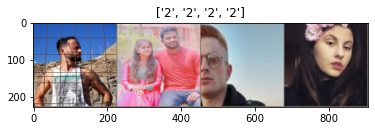

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [7]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.8551 Acc: 0.5020
val Loss: 0.5893 Acc: 0.7107

Epoch 1/24
----------
train Loss: 0.7087 Acc: 0.6392
val Loss: 0.9892 Acc: 0.5702

Epoch 2/24
----------
train Loss: 0.7709 Acc: 0.6353
val Loss: 0.6281 Acc: 0.7107

Epoch 3/24
----------
train Loss: 0.6389 Acc: 0.6902
val Loss: 1.0084 Acc: 0.5950

Epoch 4/24
----------
train Loss: 0.7758 Acc: 0.6627
val Loss: 0.7024 Acc: 0.6281

Epoch 5/24
----------
train Loss: 0.6982 Acc: 0.7137
val Loss: 1.2468 Acc: 0.5207

Epoch 6/24
----------
train Loss: 0.7428 Acc: 0.6588
val Loss: 0.7316 Acc: 0.6612

Epoch 7/24
----------
train Loss: 0.4899 Acc: 0.7412
val Loss: 0.5828 Acc: 0.7273

Epoch 8/24
----------
train Loss: 0.4370 Acc: 0.7882
val Loss: 0.5968 Acc: 0.7355

Epoch 9/24
----------
train Loss: 0.4237 Acc: 0.8235
val Loss: 0.5338 Acc: 0.7521

Epoch 10/24
----------
train Loss: 0.4317 Acc: 0.7804
val Loss: 0.5534 Acc: 0.7438

Epoch 11/24
----------
train Loss: 0.4270 Acc: 0.7922
val Loss: 0.5170 Acc: 0.7769

Ep

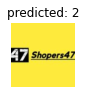

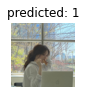

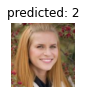

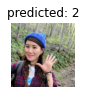

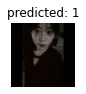

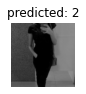

In [9]:
visualize_model(model_ft)

In [10]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [11]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.8859 Acc: 0.5333
val Loss: 0.6967 Acc: 0.6033

Epoch 1/24
----------
train Loss: 1.0027 Acc: 0.5686
val Loss: 1.5692 Acc: 0.3554

Epoch 2/24
----------
train Loss: 0.8785 Acc: 0.5843
val Loss: 1.5446 Acc: 0.3471

Epoch 3/24
----------
train Loss: 0.9041 Acc: 0.5608
val Loss: 0.8057 Acc: 0.5537

Epoch 4/24
----------
train Loss: 0.8515 Acc: 0.5647
val Loss: 0.5876 Acc: 0.7355

Epoch 5/24
----------
train Loss: 0.7498 Acc: 0.6471
val Loss: 0.5681 Acc: 0.7273

Epoch 6/24
----------
train Loss: 0.8774 Acc: 0.5804
val Loss: 0.5330 Acc: 0.7438

Epoch 7/24
----------
train Loss: 0.6191 Acc: 0.6627
val Loss: 0.5483 Acc: 0.7355

Epoch 8/24
----------
train Loss: 0.5815 Acc: 0.6980
val Loss: 0.5713 Acc: 0.7190

Epoch 9/24
----------
train Loss: 0.6345 Acc: 0.6549
val Loss: 0.5801 Acc: 0.6942

Epoch 10/24
----------
train Loss: 0.6022 Acc: 0.6824
val Loss: 0.5577 Acc: 0.7025

Epoch 11/24
----------
train Loss: 0.5900 Acc: 0.6824
val Loss: 0.5881 Acc: 0.6694

Ep

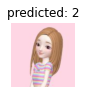

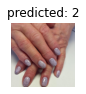

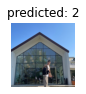

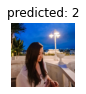

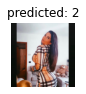

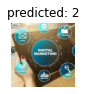

In [12]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [13]:
from PIL import Image

input_image = Image.open('photo75.jpg')
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)

In [14]:
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model_conv.to('cuda')

with torch.no_grad():
    output = model_conv(input_batch)
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
print(output[0])

tensor([-0.7083,  0.0945])


In [15]:
probabilities = torch.nn.functional.softmax(output[0], dim=0)
print(probabilities)

tensor([0.3094, 0.6906])


In [20]:
modelpath = os.getcwd()
torch.save(model_conv.state_dict(), "model.pth")